In [1]:
import pandas as pd
import numpy as np
import seaborn as sns
import datetime as dt
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split

In [2]:
from google.colab import files
uploaded = files.upload()

Saving survey-2.csv to survey-2.csv


/tmp/ipython-input-142293100.py:8: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.barplot(x=top_directions.values, y=top_directions.index, palette='magma')


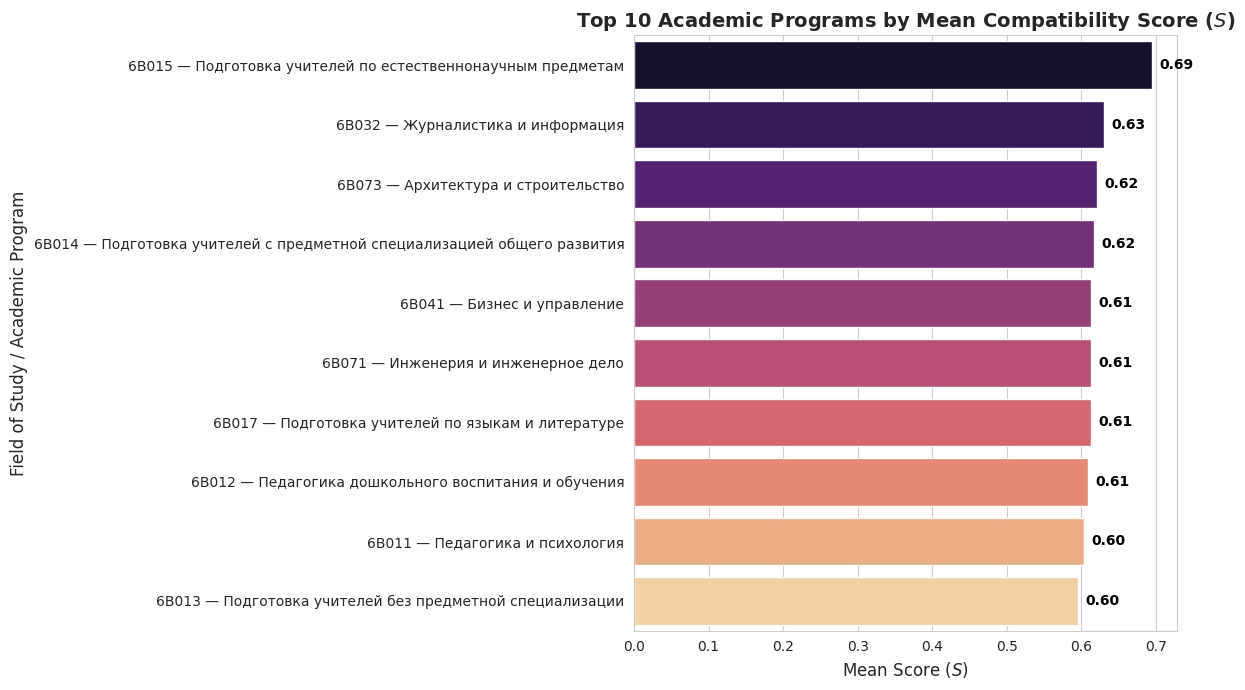

In [3]:
df = pd.read_csv('survey-2.csv', sep=';')
df['Балл (0–1) S'] = df['Балл (0–1) S'].str.replace(',', '.').astype(float)


top_directions = df.groupby('Направление подготовки')['Балл (0–1) S'].mean().sort_values(ascending=False).head(10)
plt.figure(figsize=(12, 7))
sns.set_style("whitegrid")
ax = sns.barplot(x=top_directions.values, y=top_directions.index, palette='magma')


plt.title('Top 10 Academic Programs by Mean Compatibility Score ($S$)', fontsize=14, fontweight='bold')
plt.xlabel('Mean Score ($S$)', fontsize=12)
plt.ylabel('Field of Study / Academic Program', fontsize=12)

for i, v in enumerate(top_directions.values):
    ax.text(v + 0.01, i, f'{v:.2f}', color='black', va='center', fontweight='bold')

plt.tight_layout()
plt.show()

/tmp/ipython-input-3873998765.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  ax = sns.boxplot(x='Фактор', y='Балл (0–1) S', data=df, palette='Set2')
/tmp/ipython-input-3873998765.py:8: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(['Interests','Knowledge','Values', 'Skills'])


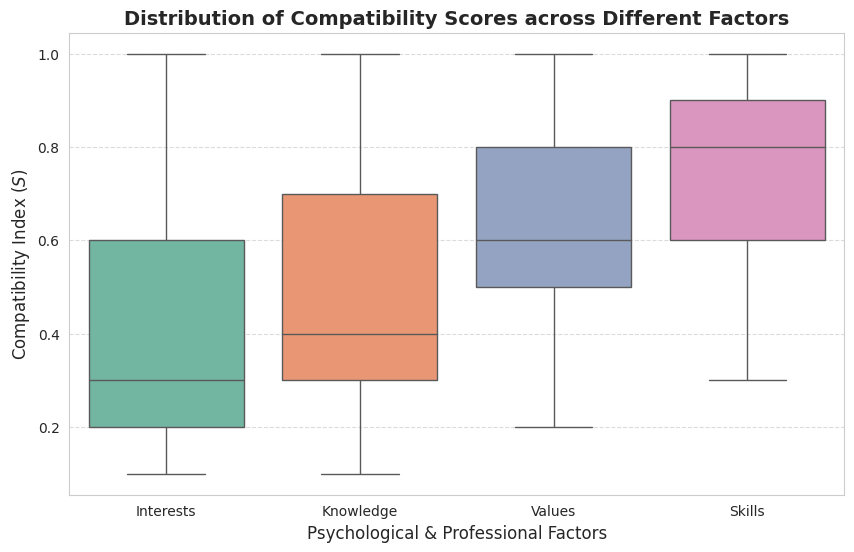

In [4]:
plt.figure(figsize=(10, 6))


ax = sns.boxplot(x='Фактор', y='Балл (0–1) S', data=df, palette='Set2')
plt.title('Distribution of Compatibility Scores across Different Factors', fontsize=14, fontweight='bold')
plt.xlabel('Psychological & Professional Factors', fontsize=12)
plt.ylabel('Compatibility Index ($S$)', fontsize=12)
ax.set_xticklabels(['Interests','Knowledge','Values', 'Skills'])

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.show()

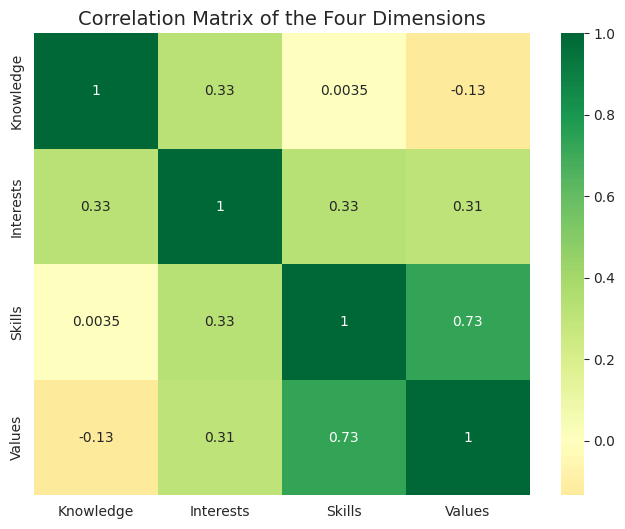

In [5]:
factor_map = {
    'Интересы': 'Interests',
    'Знания': 'Knowledge',
    'Ценности': 'Values',
    'Навыки': 'Skills'
}

df_means = df.groupby('Фактор')['Балл (0–1) S'].mean().reset_index()
df_means['Фактор'] = df_means['Фактор'].map(factor_map)

pivot_corr = df.pivot_table(index='Направление подготовки', columns='Фактор', values='Балл (0–1) S').corr()
pivot_corr.columns = [factor_map[col] for col in pivot_corr.columns]
pivot_corr.index = [factor_map[ind] for ind in pivot_corr.index]

plt.figure(figsize=(8, 6))
sns.heatmap(pivot_corr, annot=True, cmap='RdYlGn', center=0)
plt.title('Correlation Matrix of the Four Dimensions', fontsize=14)
plt.show()

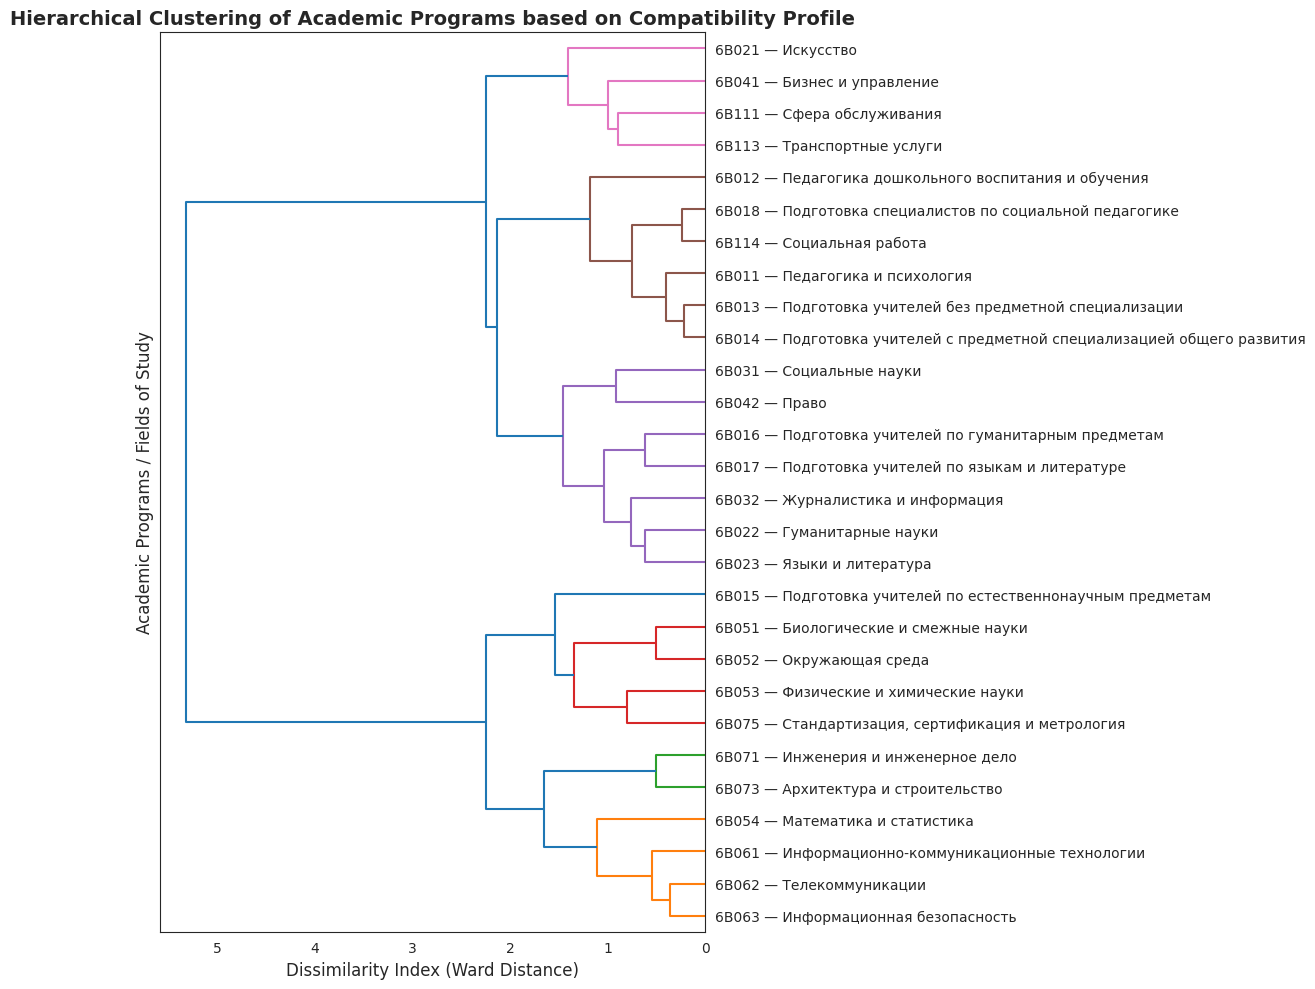

In [6]:
from scipy.cluster.hierarchy import dendrogram, linkage

pivot_df = df.pivot_table(index='Направление подготовки', columns='Вопрос', values='Балл (0–1) S').fillna(0)
linked = linkage(pivot_df, method='ward')
plt.figure(figsize=(12, 10))
sns.set_style("white")

dendrogram(
    linked,
    labels=pivot_df.index,
    orientation='left',
    distance_sort='descending',
    leaf_font_size=10,
    color_threshold=1.5
)

plt.title('Hierarchical Clustering of Academic Programs based on Compatibility Profile', fontsize=14, fontweight='bold')
plt.xlabel('Dissimilarity Index (Ward Distance)', fontsize=12)
plt.ylabel('Academic Programs / Fields of Study', fontsize=12)
plt.tight_layout()
plt.show()

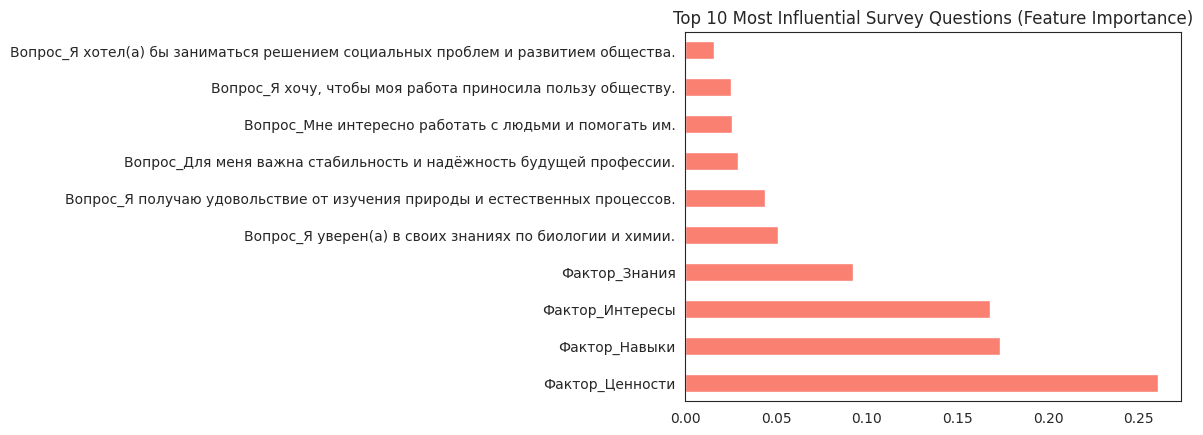

In [7]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder

le = LabelEncoder()
df_encoded = df.copy()
df_encoded['Направление_encoded'] = le.fit_transform(df['Направление подготовки'])
df_encoded['Фактор_encoded'] = le.fit_transform(df['Фактор'])

X = pd.get_dummies(df[['Вопрос', 'Фактор']])
y = df['Балл (0–1) S']

model = RandomForestRegressor(n_estimators=100)
model.fit(X, y)

feat_importances = pd.Series(model.feature_importances_, index=X.columns)
feat_importances.nlargest(10).plot(kind='barh', color='salmon')
plt.title('Top 10 Most Influential Survey Questions (Feature Importance)')
plt.show()

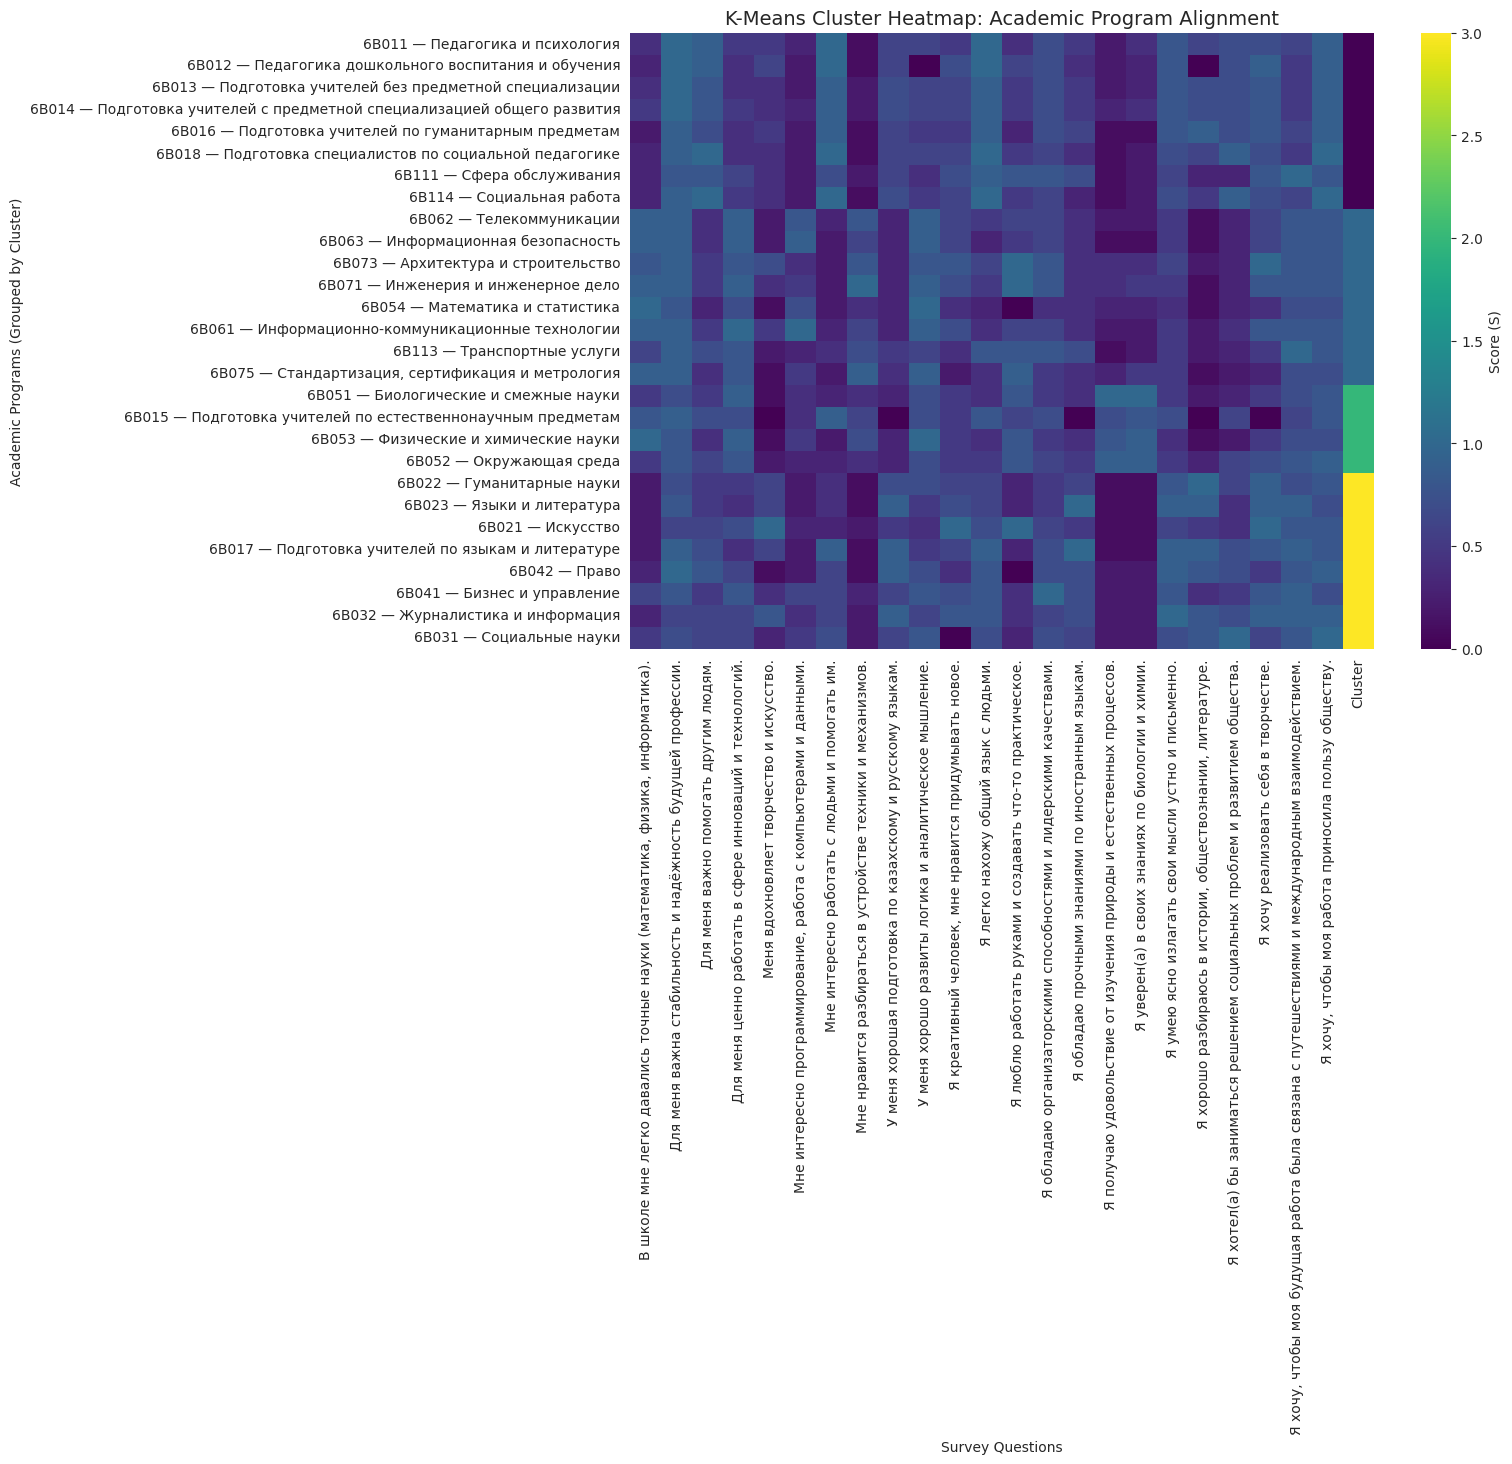

Silhouette Score (Model Accuracy): 0.230


In [8]:
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score

matrix = df.pivot_table(index='Направление подготовки', columns='Вопрос', values='Балл (0–1) S').fillna(0)

kmeans = KMeans(n_clusters=4, random_state=42, n_init=10)
matrix['Cluster'] = kmeans.fit_predict(matrix)
plt.figure(figsize=(12, 8))
sns.heatmap(matrix.sort_values('Cluster'), cmap='viridis', cbar_kws={'label': 'Score (S)'})
plt.title('K-Means Cluster Heatmap: Academic Program Alignment', fontsize=14)
plt.xlabel('Survey Questions')
plt.ylabel('Academic Programs (Grouped by Cluster)')
plt.show()

score = silhouette_score(matrix.drop('Cluster', axis=1), matrix['Cluster'])
print(f"Silhouette Score (Model Accuracy): {score:.3f}")

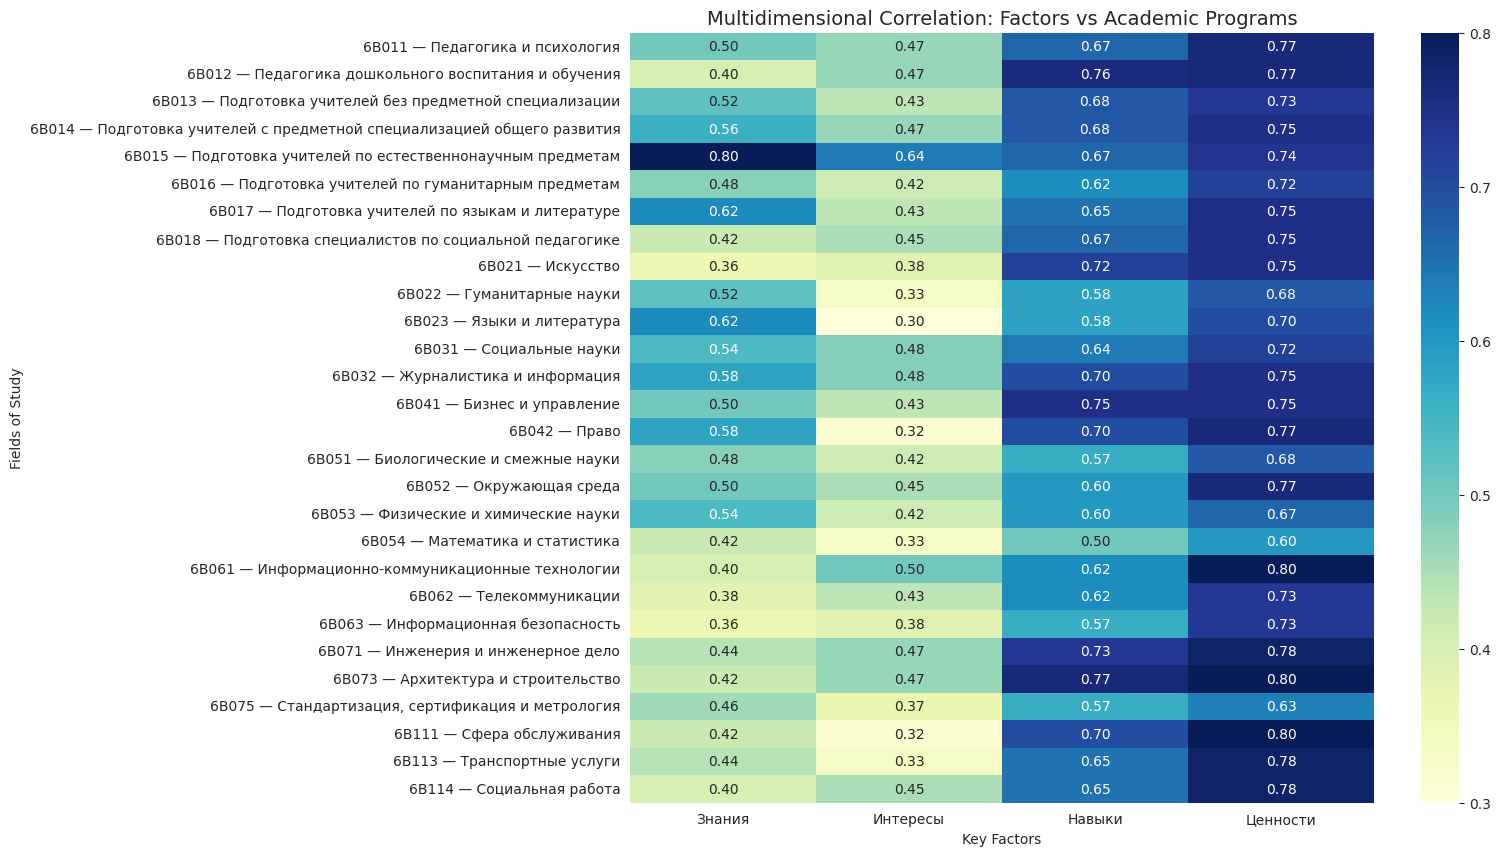

In [9]:
analysis = df.groupby(['Направление подготовки', 'Фактор'])['Балл (0–1) S'].mean().unstack()

plt.figure(figsize=(12, 10))
sns.heatmap(analysis, annot=True, cmap="YlGnBu", fmt=".2f")
plt.title('Multidimensional Correlation: Factors vs Academic Programs', fontsize=14)
plt.xlabel('Key Factors')
plt.ylabel('Fields of Study')
plt.show()

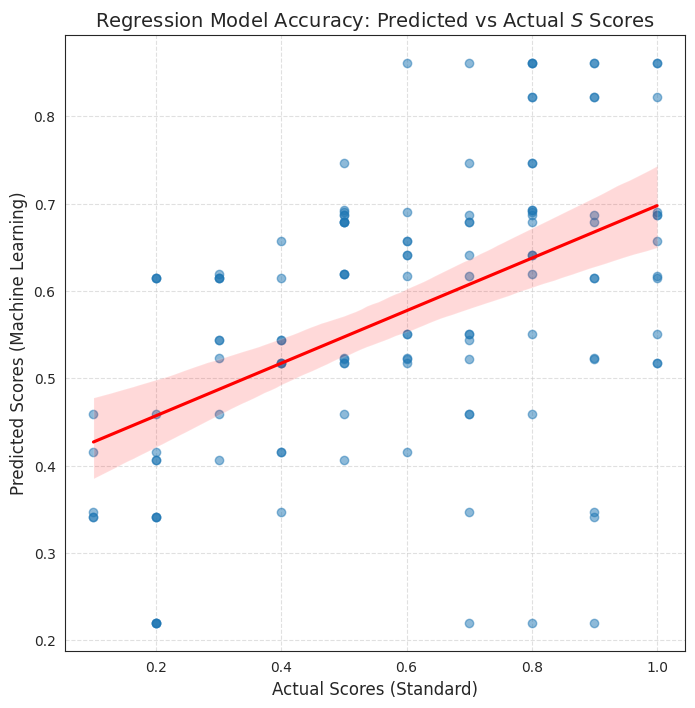

In [10]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import train_test_split

df = pd.read_csv('survey-2.csv', sep=';')
df['Балл (0–1) S'] = df['Балл (0–1) S'].str.replace(',', '.').astype(float)
X = pd.get_dummies(df[['Фактор', 'Вопрос']])
y = df['Балл (0–1) S']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

plt.figure(figsize=(8, 8))
sns.regplot(x=y_test, y=y_pred, scatter_kws={'alpha':0.5}, line_kws={'color':'red'})
plt.xlabel('Actual Scores (Standard)', fontsize=12)
plt.ylabel('Predicted Scores (Machine Learning)', fontsize=12)
plt.title('Regression Model Accuracy: Predicted vs Actual $S$ Scores', fontsize=14)
plt.grid(True, linestyle='--', alpha=0.6)
plt.show()

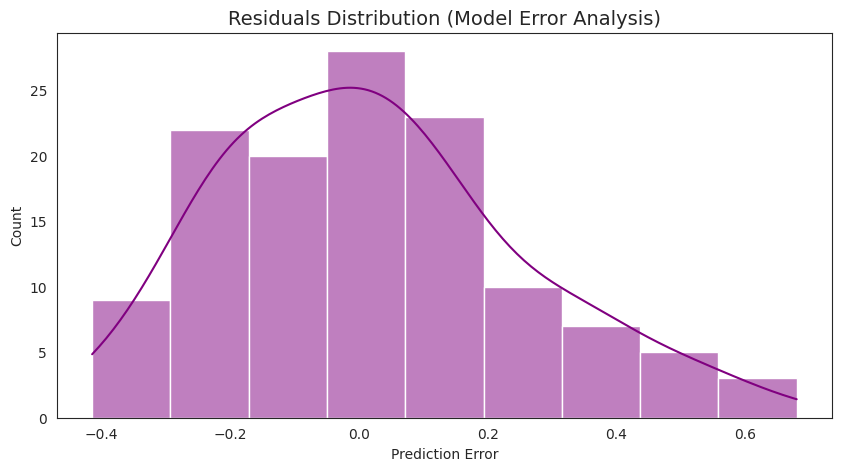

In [11]:
residuals = y_test - y_pred
plt.figure(figsize=(10, 5))
sns.histplot(residuals, kde=True, color='purple')
plt.title('Residuals Distribution (Model Error Analysis)', fontsize=14)
plt.xlabel('Prediction Error')
plt.show()